### 📘 Step 1: メタデータと画像前処理（dipCountの回帰）

今回は、画像から `dipCount`（図形のくびれ数）を予測するタスクに絞って進めます。  
600×600ピクセルの画像を入力とし、必要に応じてリサイズして学習できるようにします。

このステップでは、以下を行います：
- `metadata.csv` を読み込み、`id` と `dipCount` を抽出
- 画像のパスとラベルの対応を整理

In [1]:
import pandas as pd
from pathlib import Path

# パスの定義
DATA_DIR = Path('../../data/circle-stroke')
CSV_PATH = DATA_DIR / 'metadata.csv'
IMG_DIR = DATA_DIR / 'images'

# メタデータ読み込み
df = pd.read_csv(CSV_PATH)

# dipCountだけ使う形に絞る
df_targets = df[['id', 'dipCount']].copy()

In [2]:
# 先頭5行を表示して正しく読み込めてるか確認
df_targets.head()

,id,dipCount
0,20250521_0001,3
1,20250521_0002,5
2,20250521_0003,3
3,20250521_0004,5
4,20250521_0005,9


### 📘 Step 2: Datasetの定義（画像とdipCount）

このクラスでは、`id.png` 形式の画像を読み込んでTensorに変換し、  
対応する `dipCount` を回帰タスク用の1要素Tensorとして返します。

また、600×600の画像を扱いやすいサイズ（例：128×128）にリサイズしています。

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class DipCountDataset(Dataset):
    def __init__(self, df, img_dir, image_size=128, prefix="image_"):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.prefix = prefix
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # プレフィックスを追加してファイル名を構成
        img_filename = f"{self.prefix}{row['id']}.png"
        img_path = self.img_dir / img_filename

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        label = torch.tensor([row['dipCount']], dtype=torch.float32)

        return image, label

画像サイズ: torch.Size([3, 128, 128])
dipCountラベル: 3.0


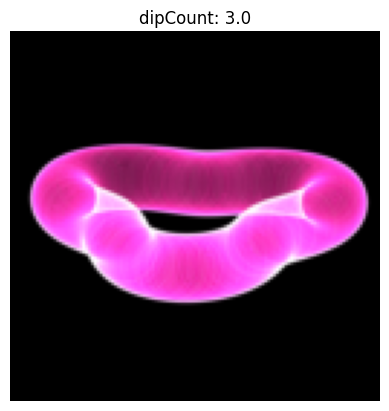

In [4]:
import matplotlib.pyplot as plt

# Datasetから1サンプル取り出し
dataset = DipCountDataset(df_targets, IMG_DIR)

img, label = dataset[0]
print(f"画像サイズ: {img.shape}")  # torch.Size([3, 128, 128])
print(f"dipCountラベル: {label.item()}")

# 画像を表示（Tensor → numpy に変換）
plt.imshow(img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title(f"dipCount: {label.item():.1f}")
plt.axis("off")
plt.show()

### 📘 Step 3: データの分割と DataLoader の作成

このステップでは、データセットを「学習用（train）」と「検証用（val）」に分割し、  
PyTorchの `DataLoader` を使ってミニバッチでデータを取り出せるようにします。

- `train_test_split()` を用いて `df_targets` を 8:2 に分割します。
- `DipCountDataset` を使って、学習用と検証用の `Dataset` を作成。
- `DataLoader` を使ってバッチ処理とシャッフル設定を行います。

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# train/val に8:2で分割
df_train, df_val = train_test_split(df_targets, test_size=0.2, random_state=42)

# Datasetのインスタンス作成
train_dataset = DipCountDataset(df_train, IMG_DIR)
val_dataset = DipCountDataset(df_val, IMG_DIR)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

バッチサイズ: torch.Size([32, 3, 128, 128])
ラベル（dipCount）: [10.0, 3.0, 4.0, 3.0, 8.0, 8.0, 5.0, 12.0, 13.0, 4.0, 7.0, 5.0, 11.0, 4.0, 4.0, 8.0, 5.0, 7.0, 13.0, 5.0, 9.0, 8.0, 4.0, 3.0, 4.0, 7.0, 10.0, 4.0, 4.0, 5.0, 4.0, 5.0]


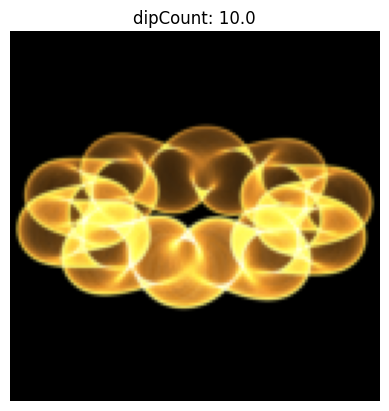

In [6]:
# バッチから画像を取り出して確認
batch = next(iter(train_loader))  # 1バッチ取り出す
images, labels = batch

print(f"バッチサイズ: {images.shape}")  # [B, C, H, W]
print(f"ラベル（dipCount）: {labels.squeeze().tolist()}")

# 最初の画像を表示
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"dipCount: {labels[0].item():.1f}")
plt.axis("off")
plt.show()

### 📘 Step 4: シンプルなCNNモデルの構築（dipCount回帰）

このステップでは、入力画像から `dipCount` を予測するための  
簡潔で読みやすいCNNモデルを定義します。

構成は以下の通りです：

- 畳み込み層（Conv2d）＋ReLU＋MaxPooling のブロックを2回
- 全結合層（Linear）で最終的に1つのスカラー値（dipCount）を出力
- 入力サイズは 128×128、出力は `1次元の実数値`

損失関数は回帰タスクなので **MSELoss（平均二乗誤差）** を使います。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class DipCountCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 128x128 → 64x64
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 64x64 → 32x32

        # 最終的な特徴マップのサイズ = 32ch, 32x32
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 1)  # dipCount（実数）を出力

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → [16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # → [32, 32, 32]
        x = x.view(x.size(0), -1)             # フラット化
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # 出力は shape=[B, 1]
        return x

In [8]:
model = DipCountCNN()

# バッチの画像を通してみる
sample_input = images[:4]  # 4枚だけ
outputs = model(sample_input)

print(f"出力のshape: {outputs.shape}")  # torch.Size([4, 1])
print(f"予測dipCount: {outputs.squeeze().tolist()}")

出力のshape: torch.Size([4, 1])
予測dipCount: [-0.029186945408582687, -0.03200441971421242, -0.027907956391572952, -0.02929677441716194]


### 📘 Step 5: 学習ループと損失の記録（dipCount回帰）

このステップでは、学習ループを構築してモデルの訓練を行います。

主な処理は以下の通りです：

- 損失関数：`nn.MSELoss()`（予測と正解の平均二乗誤差）
- 最適化手法：`Adam`（学習率は 0.001 で開始）
- エポックごとに train/val の損失を表示し、学習が進んでいるか確認します

エポック数は少なめ（例：5）から始めて、動作を確認しながら後で増やすのがおすすめです。

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# モデル、損失関数、最適化手法の設定
model = DipCountCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# GPU対応
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 学習パラメータ
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 検証ループ
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

[1/20] Train Loss: 9.6448 | Val Loss: 8.0687
[2/20] Train Loss: 5.2651 | Val Loss: 5.5673
[3/20] Train Loss: 3.9963 | Val Loss: 5.3164
[4/20] Train Loss: 2.5867 | Val Loss: 1.7586
[5/20] Train Loss: 0.7114 | Val Loss: 0.7381
[6/20] Train Loss: 0.3989 | Val Loss: 0.5689
[7/20] Train Loss: 0.2409 | Val Loss: 0.4109
[8/20] Train Loss: 0.1920 | Val Loss: 0.2516
[9/20] Train Loss: 0.1831 | Val Loss: 0.3439
[10/20] Train Loss: 0.1112 | Val Loss: 0.1876
[11/20] Train Loss: 0.0988 | Val Loss: 0.1644
[12/20] Train Loss: 0.1033 | Val Loss: 0.2091
[13/20] Train Loss: 0.1286 | Val Loss: 0.1784
[14/20] Train Loss: 0.0797 | Val Loss: 0.1751
[15/20] Train Loss: 0.0621 | Val Loss: 0.1290
[16/20] Train Loss: 0.0475 | Val Loss: 0.1324
[17/20] Train Loss: 0.0445 | Val Loss: 0.2219
[18/20] Train Loss: 0.0449 | Val Loss: 0.1217
[19/20] Train Loss: 0.0464 | Val Loss: 0.1307
[20/20] Train Loss: 0.0395 | Val Loss: 0.1005


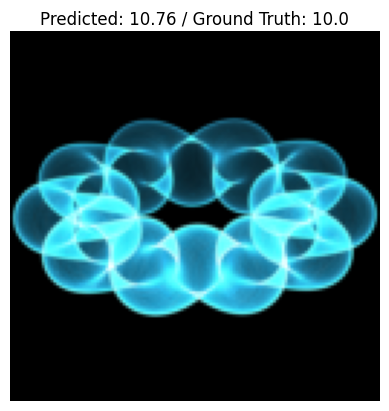

In [10]:
# 検証データから1枚予測して、目視確認してみる
model.eval()
sample_img, sample_label = val_dataset[0]
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(device)).item()

plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"Predicted: {pred:.2f} / Ground Truth: {sample_label.item():.1f}")
plt.axis("off")
plt.show()

### 📘 Step 6: 複数画像の予測と可視化

このステップでは、検証データセットから複数の画像を取り出し、  
CNNモデルによる `dipCount` の予測結果と正解ラベルを並べて確認します。

視覚的に「どの程度当たっているか」「どんな画像で外しているか」などをチェックするのに有効です。

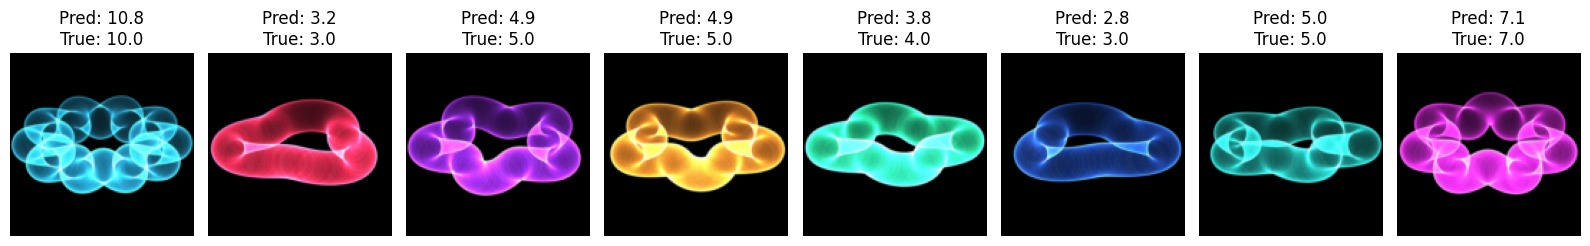

In [11]:
model.eval()
num_samples = 8

plt.figure(figsize=(16, 4))
for i in range(num_samples):
    sample_img, sample_label = val_dataset[i]
    with torch.no_grad():
        pred = model(sample_img.unsqueeze(0).to(device)).item()

    plt.subplot(1, num_samples, i+1)
    plt.imshow(sample_img.permute(1, 2, 0))
    plt.title(f"Pred: {pred:.1f}\nTrue: {sample_label.item():.1f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### 📘 Step 7: ロスの推移をグラフで可視化

このステップでは、学習中に記録した train/val の損失値をグラフにして可視化します。

- 損失が徐々に下がっているか
- train と val の間に大きなギャップが生じていないか（過学習）

などを確認することで、モデルの改善ポイントを見つけやすくなります。

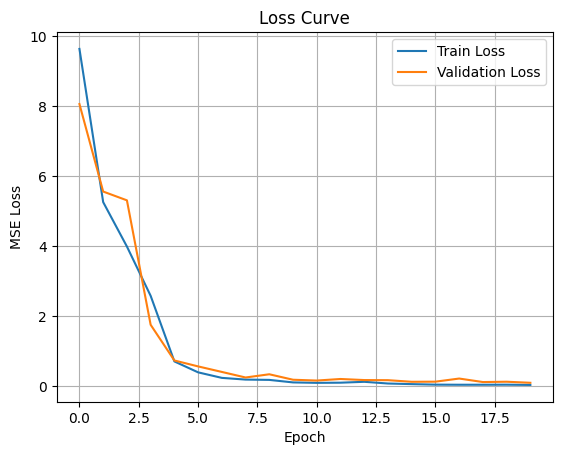

In [12]:
# ロスの推移をグラフにする
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()